# Comparison of Blending Methods for DRAEM

This notebook visualizes and compares three blending methods:
1. **Uniform Beta**: Constant blending factor across the entire anomaly region
2. **Perlin Beta**: Spatially-varying blending using Perlin noise
3. **Poisson Image Interpolation**: Gradient-domain seamless blending

The goal is to verify that:
- Poisson blending creates seamless transitions
- Alpha values in [0, 0.8] produce comparable overlay strengths to beta
- All methods work correctly with arbitrary Perlin mask shapes

In [1]:
%load_ext autoreload
%autoreload 2

import imgaug

import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from data_loader import MVTecDRAEMTrainDataset
import os


## Setup Dataset Paths

In [2]:
# Configure paths (adjust these to your setup)
data_path = './datasets/mvtec/capsule/train/good/'
anomaly_source_path = './datasets/dtd/images/'
resize_shape = [256, 256]

# Check if paths exist
if not os.path.exists(data_path):
    print(f"Warning: data_path does not exist: {data_path}")
    print("Please update the paths in the notebook.")
if not os.path.exists(anomaly_source_path):
    print(f"Warning: anomaly_source_path does not exist: {anomaly_source_path}")
    print("Please update the paths in the notebook.")

## Load Datasets with Different Blending Methods

In [3]:
# Create datasets with different blending methods
dataset_uniform = MVTecDRAEMTrainDataset(
    data_path, anomaly_source_path, 
    resize_shape=resize_shape, 
    blend_method='beta_uniform',
    image_limit=5,
    texture_limit=5,
)

dataset_perlin = MVTecDRAEMTrainDataset(
    data_path, anomaly_source_path, 
    resize_shape=resize_shape, 
    blend_method='beta_perlin',
    image_limit=5,
    texture_limit=5,
)

dataset_poisson = MVTecDRAEMTrainDataset(
    data_path, anomaly_source_path, 
    resize_shape=resize_shape, 
    blend_method='poisson',
    image_limit=5,
    texture_limit=5,
)

print(f"Loaded {len(dataset_uniform)} training images")

Loading 5 training images into memory...
Finished loading training images.
Loading 5 anomaly source images into memory...
Finished loading anomaly source images.
Loading 5 training images into memory...
Finished loading training images.
Loading 5 anomaly source images into memory...
Finished loading anomaly source images.
Loading 5 training images into memory...
Finished loading training images.
Loading 5 anomaly source images into memory...
Finished loading anomaly source images.
Loaded 5 training images


## Generate Samples with Each Method

In [4]:
def get_sample_with_anomaly(dataset, max_attempts=10):
    """Get a sample that has an anomaly (not a no-anomaly case)."""
    for _ in range(max_attempts):
        sample = dataset[0]  # Random sample due to dataset implementation
        if sample['has_anomaly'][0] > 0.5:
            return sample
    raise ValueError("Could not get sample with anomaly after many attempts")

# Generate samples with synchronized random state
# The key is to use the same number of dataset accesses for each method
# by pre-determining which attempt will have an anomaly

def get_samples_synchronized(datasets, seed=42, max_attempts=50):
    """
    Generate samples from multiple datasets with the same underlying randomness.
    This ensures all three methods use the same mask shape and image.
    Only accepts samples where ALL blending methods produce an anomaly.
    """
    for attempt in range(max_attempts):
        current_seed = seed + attempt
        samples = []
        all_have_anomaly = True
        
        for dataset in datasets:
            np.random.seed(current_seed)
            imgaug.seed(current_seed)
            torch.manual_seed(current_seed)
            
            temp_sample = dataset[0]
            samples.append(temp_sample)
            
            # Check if this sample has an anomaly
            if temp_sample['has_anomaly'][0] <= 0.5:
                all_have_anomaly = False
                break
        
        # If all datasets produced samples with anomalies, return them
        if all_have_anomaly:
            return samples
    
    raise ValueError(f"Could not get samples with anomalies for all methods after {max_attempts} attempts")

# Generate synchronized samples
print("Generating synchronized samples...")
sample_uniform, sample_perlin, sample_poisson = get_samples_synchronized(
    [dataset_uniform, dataset_perlin, dataset_poisson],
    seed=167
)

Generating synchronized samples...


## Visualization Function

In [5]:
def visualize_sample(sample, title="Sample"):
    """Visualize a single sample with all its components."""
    # Convert from (C, H, W) to (H, W, C) for display
    original = np.transpose(sample['image'], (1, 2, 0))
    augmented = np.transpose(sample['augmented_image'], (1, 2, 0))
    mask = np.transpose(sample['anomaly_mask'], (1, 2, 0))
    beta_map = np.transpose(sample['beta_map'], (1, 2, 0))
    anomaly_source = np.transpose(sample['anomaly_source_img'], (1, 2, 0))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # Row 1: Original, Augmented, Difference
    axes[0, 0].imshow(original)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(augmented)
    axes[0, 1].set_title('Augmented Image (with Anomaly)')
    axes[0, 1].axis('off')
    
    # Compute and display difference
    diff = np.abs(augmented - original)
    axes[0, 2].imshow(diff)
    axes[0, 2].set_title('Absolute Difference')
    axes[0, 2].axis('off')
    
    # Row 2: Anomaly Source, Mask, Beta/Alpha Map
    axes[1, 0].imshow(anomaly_source)
    axes[1, 0].set_title('Anomaly Source Texture')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(mask[:, :, 0], cmap='gray')
    axes[1, 1].set_title('Anomaly Mask (Perlin)')
    axes[1, 1].axis('off')
    
    im = axes[1, 2].imshow(beta_map[:, :, 0], cmap='viridis', vmin=0, vmax=0.8)
    axes[1, 2].set_title('Beta/Alpha Map')
    axes[1, 2].axis('off')
    plt.colorbar(im, ax=axes[1, 2], fraction=0.046)
    
    plt.tight_layout()
    return fig

## Compare All Three Methods Side-by-Side

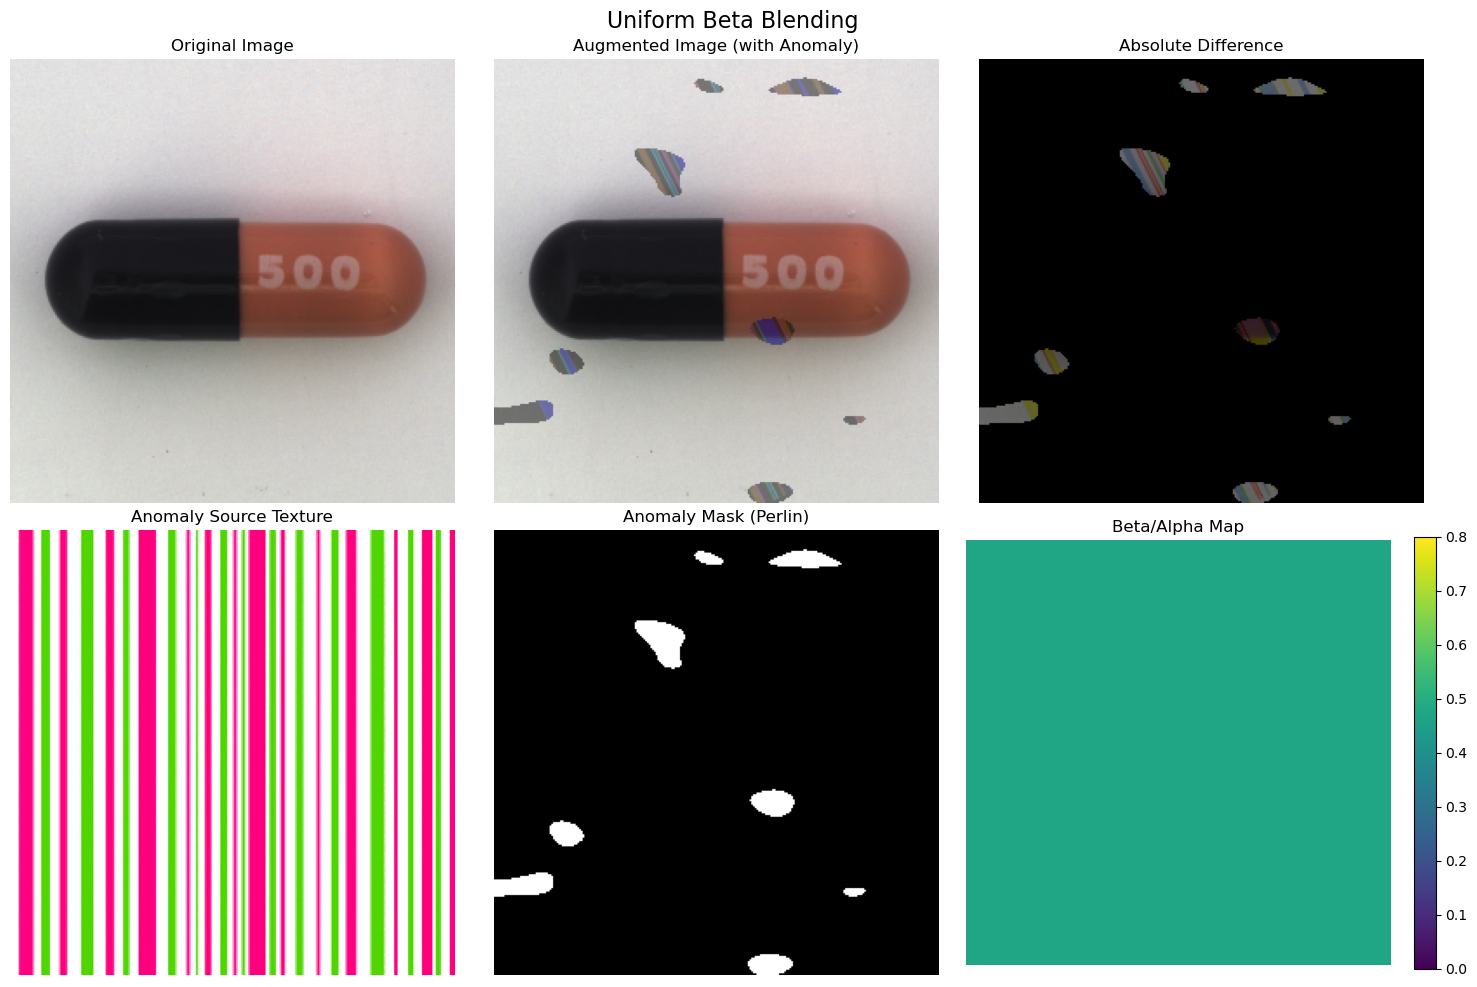

In [6]:
# Visualize Uniform Beta
fig1 = visualize_sample(sample_uniform, title="Uniform Beta Blending")
plt.show()

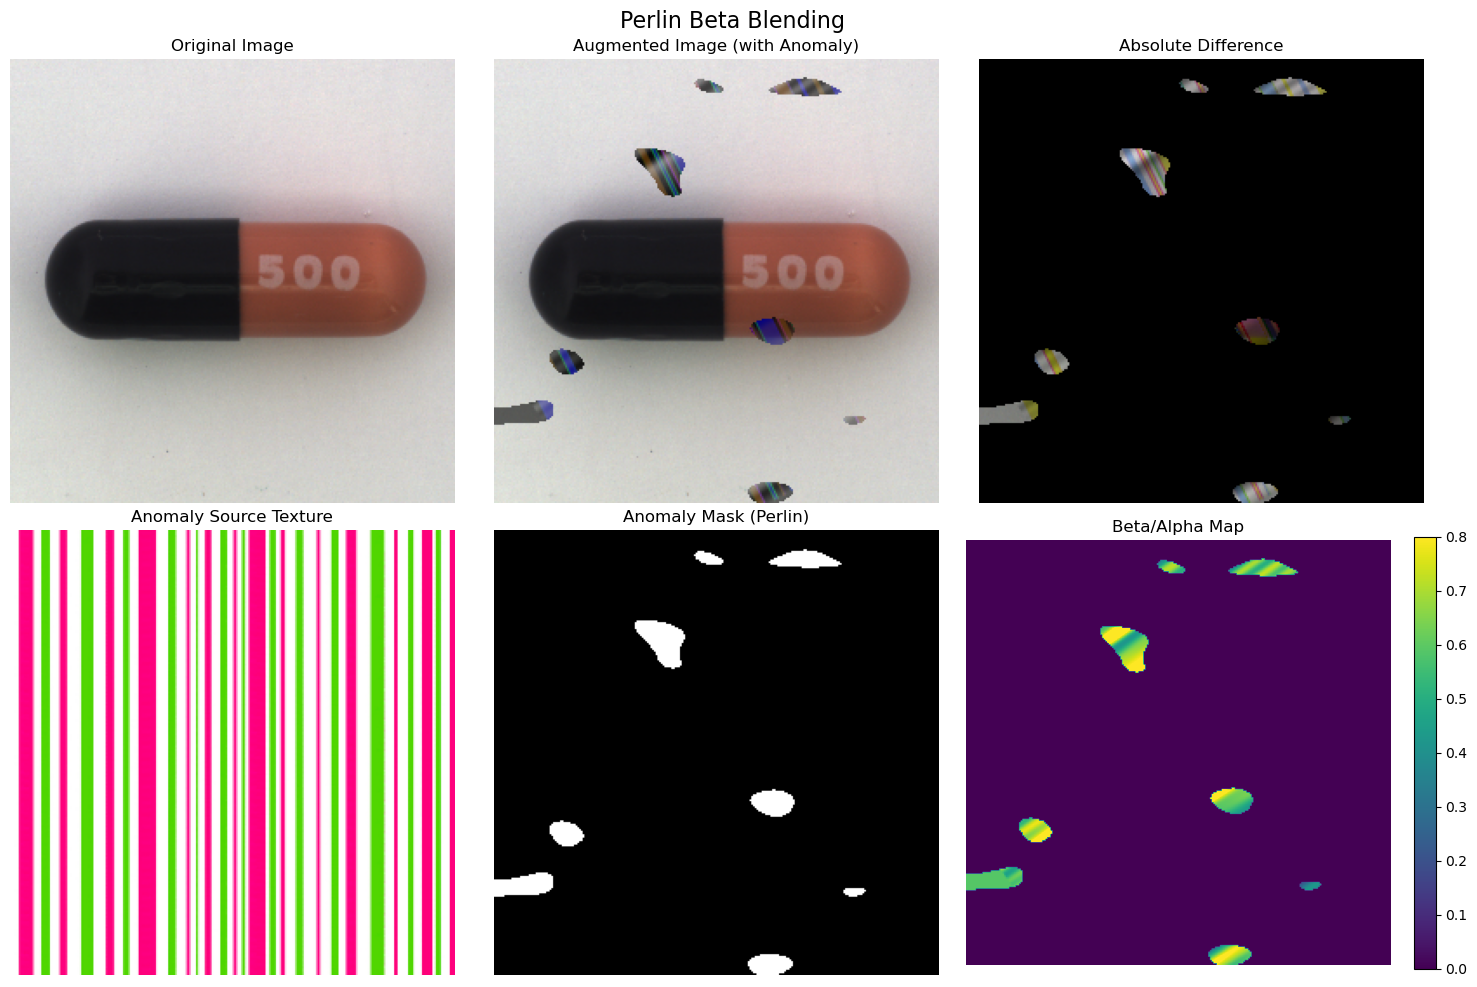

In [7]:
# Visualize Perlin Beta
fig2 = visualize_sample(sample_perlin, title="Perlin Beta Blending")
plt.show()

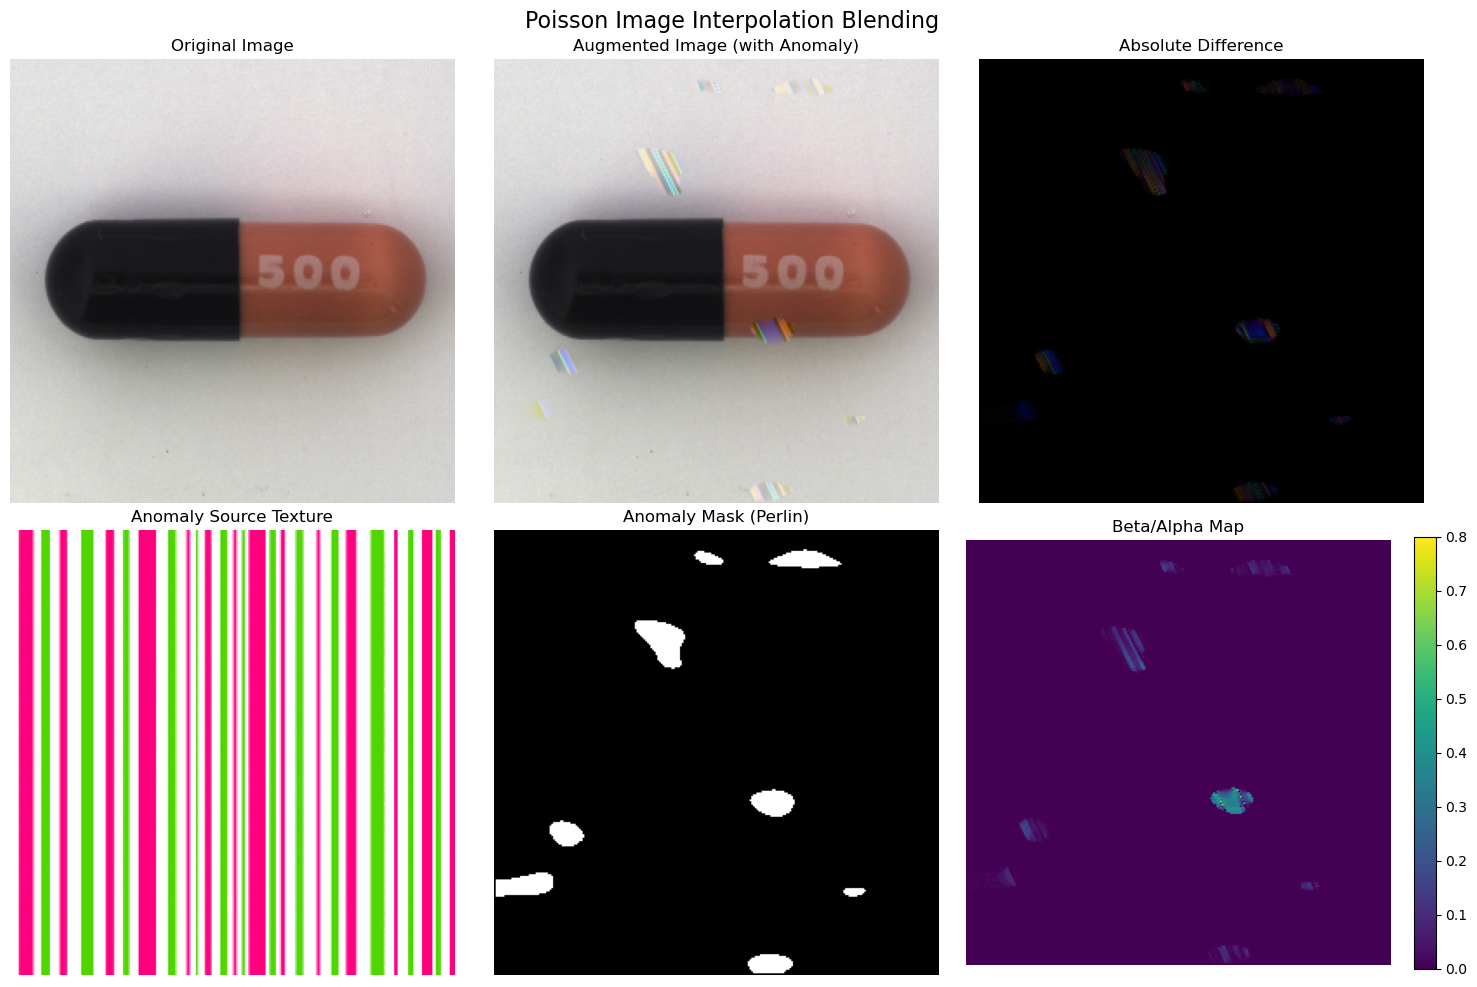

In [8]:
# Visualize Poisson
fig3 = visualize_sample(sample_poisson, title="Poisson Image Interpolation Blending")
plt.show()

## Direct Comparison of Augmented Images

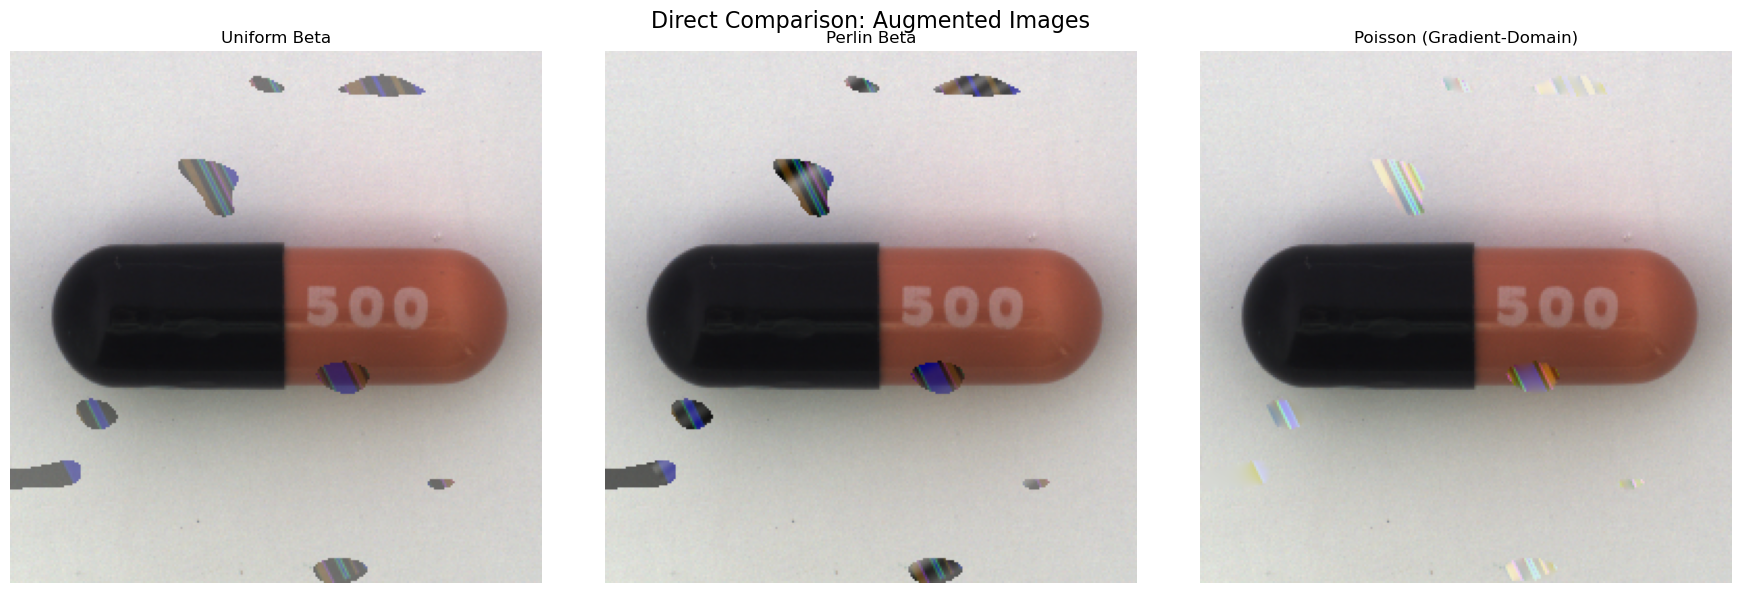

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Direct Comparison: Augmented Images', fontsize=16)

axes[0].imshow(np.transpose(sample_uniform['augmented_image'], (1, 2, 0)))
axes[0].set_title('Uniform Beta')
axes[0].axis('off')

axes[1].imshow(np.transpose(sample_perlin['augmented_image'], (1, 2, 0)))
axes[1].set_title('Perlin Beta')
axes[1].axis('off')

axes[2].imshow(np.transpose(sample_poisson['augmented_image'], (1, 2, 0)))
axes[2].set_title('Poisson (Gradient-Domain)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Analyze Blending Strengths

Compare the beta/alpha values to ensure Poisson produces comparable overlay strengths.

In [10]:
def analyze_blending_strength(sample, method_name):
    """Analyze the blending strength statistics."""
    beta_map = sample['beta_map'][0]  # First channel
    mask = sample['anomaly_mask'][0]
    
    # Get beta/alpha values only in the masked region
    masked_values = beta_map[mask > 0.5]
    
    if len(masked_values) > 0:
        print(f"\n{method_name}:")
        print(f"  Mean beta/alpha: {masked_values.mean():.4f}")
        print(f"  Min beta/alpha:  {masked_values.min():.4f}")
        print(f"  Max beta/alpha:  {masked_values.max():.4f}")
        print(f"  Std beta/alpha:  {masked_values.std():.4f}")
    else:
        print(f"\n{method_name}: No masked region found")

analyze_blending_strength(sample_uniform, "Uniform Beta")
analyze_blending_strength(sample_perlin, "Perlin Beta")
analyze_blending_strength(sample_poisson, "Poisson Alpha")

print("\nNote: All values should be in the range [0, 0.8] for fair comparison.")


Uniform Beta:
  Mean beta/alpha: 0.4748
  Min beta/alpha:  0.4748
  Max beta/alpha:  0.4748
  Std beta/alpha:  0.0000

Perlin Beta:
  Mean beta/alpha: 0.6421
  Min beta/alpha:  0.2208
  Max beta/alpha:  0.9608
  Std beta/alpha:  0.1296

Poisson Alpha:
  Mean beta/alpha: 0.0793
  Min beta/alpha:  0.0000
  Max beta/alpha:  0.7371
  Std beta/alpha:  0.1072

Note: All values should be in the range [0, 0.8] for fair comparison.


## Zoom-In on Anomaly Boundaries

Examine the boundaries to see the seamless blending effect of Poisson interpolation.

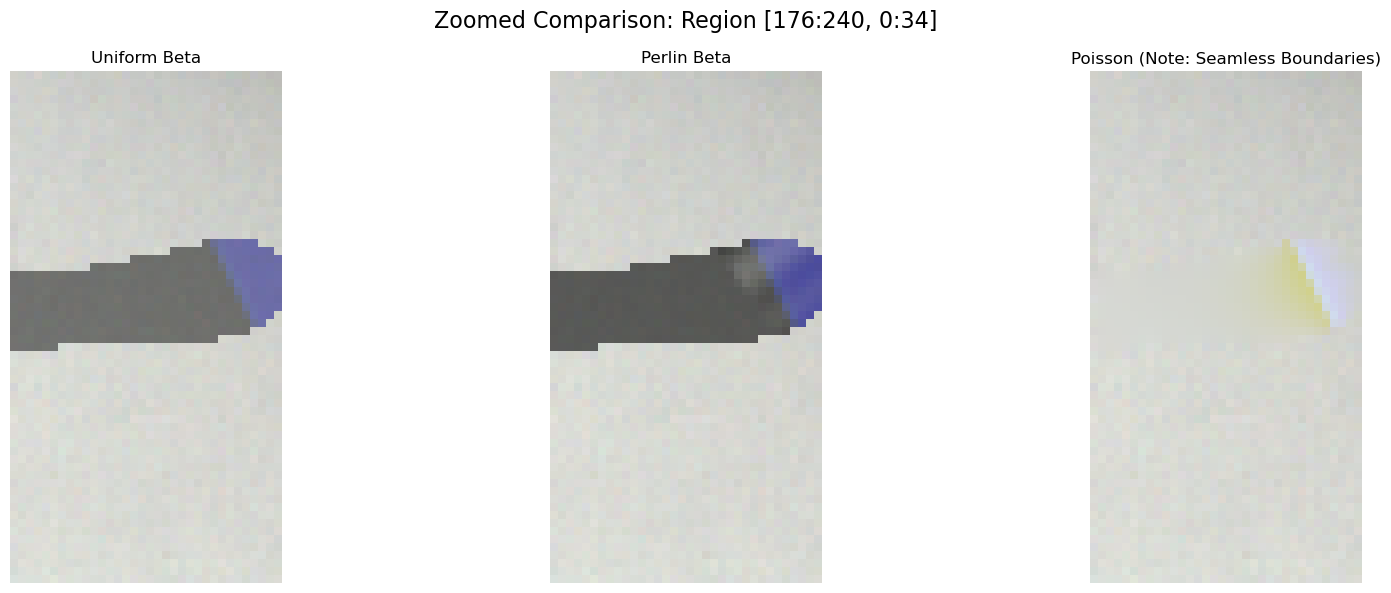

In [11]:
def show_zoomed_comparison(sample_uniform, sample_perlin, sample_poisson, zoom_region=None):
    """Show zoomed-in comparison of the three methods."""
    if zoom_region is None:
        # Find a region with anomaly
        mask = sample_uniform['anomaly_mask'][0]
        # Find first 5x5 patch where all pixels have mask > 0.5
        found = False
        for i in range(mask.shape[0] - 4):
            for j in range(mask.shape[1] - 4):
                if np.all(mask[i:i+5, j:j+5] > 0.5):
                    cy, cx = i + 2, j + 2  # Center of 5x5 patch
                    found = True
                    break
                if found:
                    break
        
        if found:
            # Create 64x64 zoom region around center
            zoom_region = (max(0, cy-32), min(256, cy+32), 
                          max(0, cx-32), min(256, cx+32))
        else:
            zoom_region = (96, 160, 96, 160)  # Default center region
    
    y1, y2, x1, x2 = zoom_region
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Zoomed Comparison: Region [{y1}:{y2}, {x1}:{x2}]', fontsize=16)
    
    img_uniform = np.transpose(sample_uniform['augmented_image'], (1, 2, 0))[y1:y2, x1:x2]
    img_perlin = np.transpose(sample_perlin['augmented_image'], (1, 2, 0))[y1:y2, x1:x2]
    img_poisson = np.transpose(sample_poisson['augmented_image'], (1, 2, 0))[y1:y2, x1:x2]
    
    axes[0].imshow(img_uniform)
    axes[0].set_title('Uniform Beta')
    axes[0].axis('off')
    
    axes[1].imshow(img_perlin)
    axes[1].set_title('Perlin Beta')
    axes[1].axis('off')
    
    axes[2].imshow(img_poisson)
    axes[2].set_title('Poisson (Note: Seamless Boundaries)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

show_zoomed_comparison(sample_uniform, sample_perlin, sample_poisson)

## Test with Multiple Samples

Generate and compare multiple samples to verify consistency.


Generating Poisson samples...


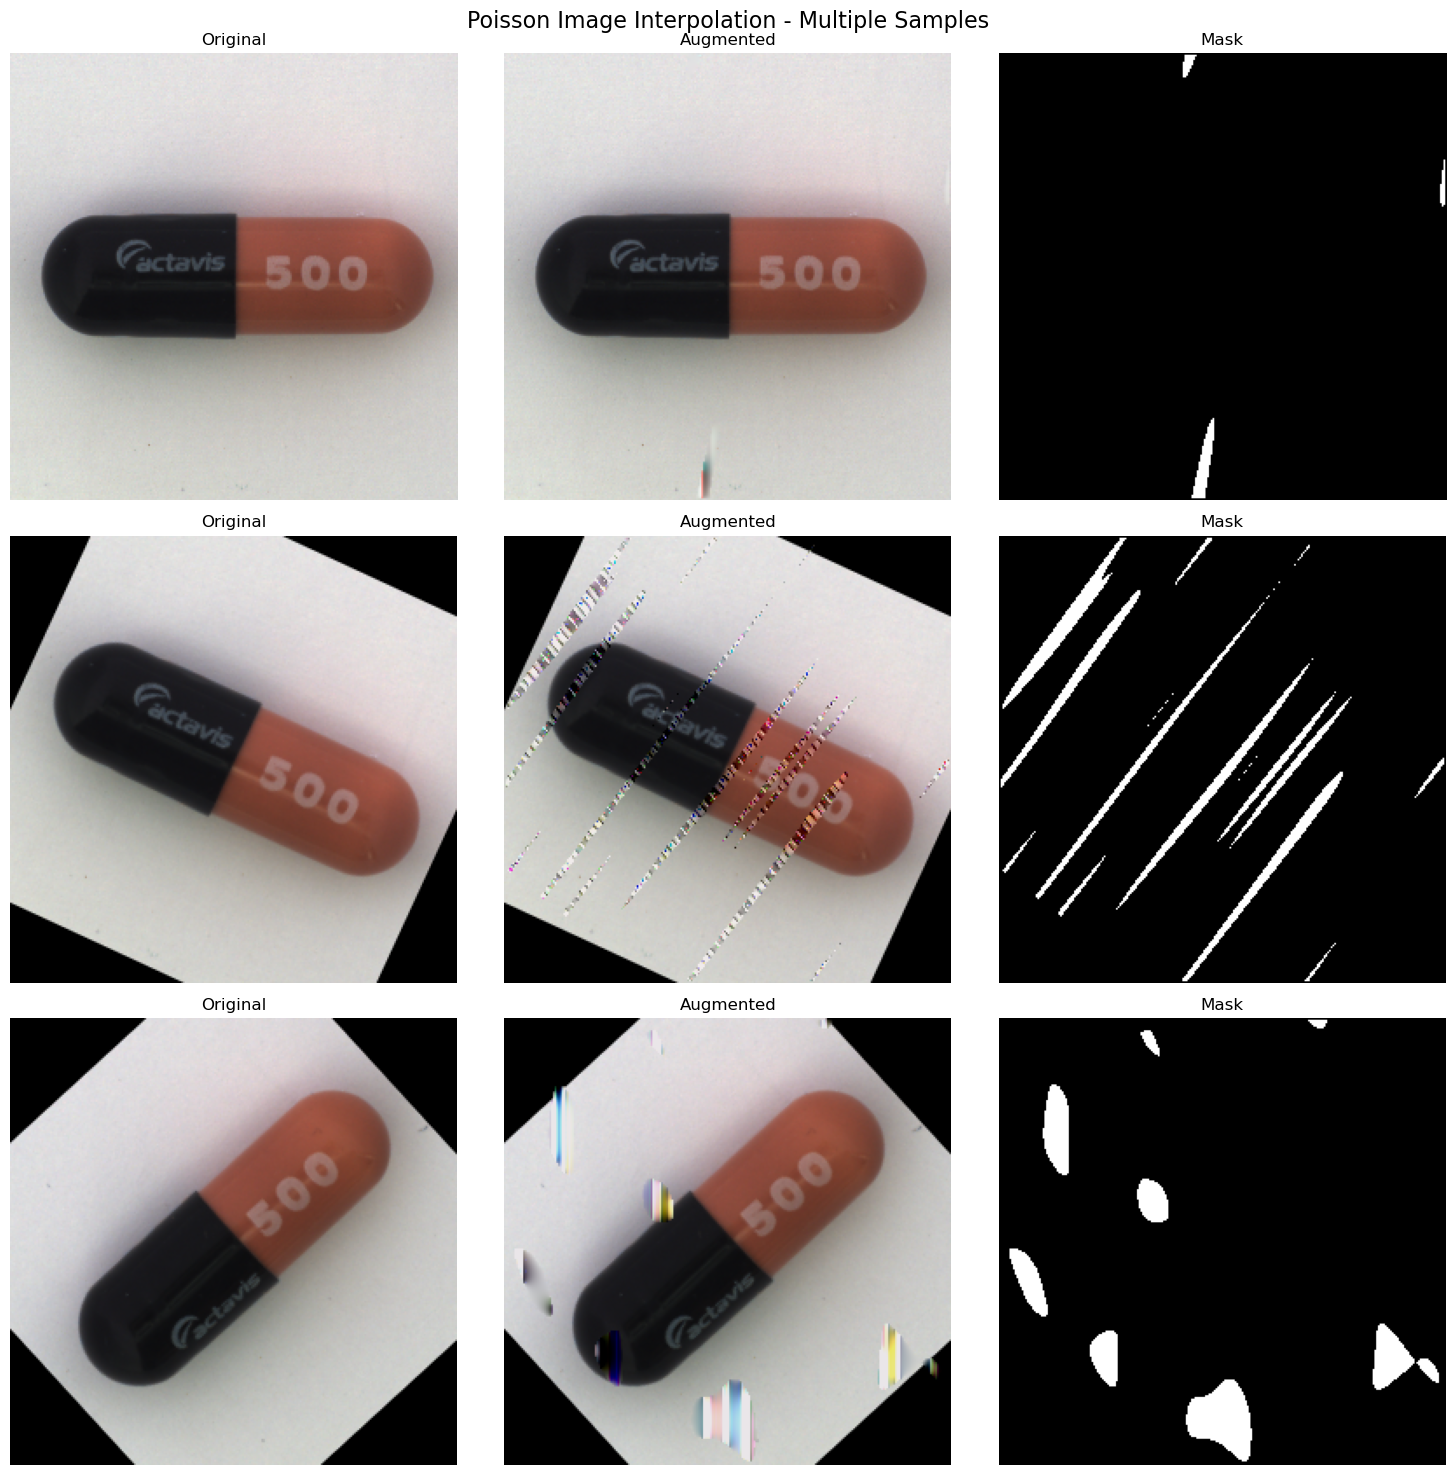

In [12]:
def generate_comparison_grid(dataset, method_name, n_samples=3):
    """Generate a grid of samples from a dataset."""
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
    fig.suptitle(f'{method_name} - Multiple Samples', fontsize=16)
    
    for i in range(n_samples):
        sample = get_sample_with_anomaly(dataset)
        
        original = np.transpose(sample['image'], (1, 2, 0))
        augmented = np.transpose(sample['augmented_image'], (1, 2, 0))
        mask = np.transpose(sample['anomaly_mask'], (1, 2, 0))
        
        axes[i, 0].imshow(original)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(augmented)
        axes[i, 1].set_title('Augmented')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(mask[:, :, 0], cmap='gray')
        axes[i, 2].set_title('Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate comparison grids
print("\nGenerating Poisson samples...")
generate_comparison_grid(dataset_poisson, "Poisson Image Interpolation", n_samples=3)

## Summary and Observations

### Expected Observations:

1. **Uniform Beta**: 
   - Constant blending throughout anomaly region
   - May show visible seams at boundaries if texture brightness differs from image
   - Beta map is uniform (single color in visualization)

2. **Perlin Beta**:
   - Spatially-varying blending creates more natural-looking anomalies
   - Beta map shows Perlin noise pattern
   - Still may have some artifacts at boundaries

3. **Poisson Image Interpolation**:
   - Seamless boundaries due to gradient-domain blending
   - Preserves structural details from both source and destination
   - Alpha map is uniform but blending respects image gradients
   - Should produce more realistic and challenging anomalies

### Next Steps:
- Train models with each blending method
- Compare AUROC and AP metrics on test set
- Evaluate if Poisson blending improves generalization to real anomalies